nhaatj ## ResNet (PyTorch Implementation)

In [15]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [16]:
%run data.ipynb

Data root: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\input
Total Trainable Data:  112120
Training set size:  60
Validation set size:  20
Test set size:  20
Images path: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\input
Training batches: 2
Validation batches: 1
Test batches: 1


In [17]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Hyperparameters
learning_rate = 1e-4
weight_decay = 1e-6
num_epochs = 10
num_classes = 15

In [19]:
# ResNet Basic Block
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out

# ResNet-34 Model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=15):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def create_resnet34(num_classes=15):
    """Create ResNet-34 model"""
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_auc': [],
        'val_auc': []
    }
    
    best_val_auc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training Phase
        model.train()
        running_loss = 0.0
        all_targets = []
        all_outputs = []
        
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            # For AUC calculation
            all_targets.append(labels.cpu().detach().numpy())
            all_outputs.append(torch.sigmoid(outputs).cpu().detach().numpy())
            
        epoch_loss = running_loss / len(train_loader.dataset)
        all_targets = np.vstack(all_targets)
        all_outputs = np.vstack(all_outputs)
        
        # Calculate AUC only for classes with both positive and negative samples
        try:
            valid_classes = []
            for i in range(all_targets.shape[1]):
                if len(np.unique(all_targets[:, i])) > 1:
                    valid_classes.append(i)
            
            if len(valid_classes) > 0:
                epoch_auc = roc_auc_score(
                    all_targets[:, valid_classes], 
                    all_outputs[:, valid_classes], 
                    average='macro'
                )
            else:
                epoch_auc = 0.0
        except ValueError:
            epoch_auc = 0.0
            
        history['train_loss'].append(epoch_loss)
        history['train_auc'].append(epoch_auc)
        
        print(f'Train Loss: {epoch_loss:.4f} AUC: {epoch_auc:.4f}')
        
        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        val_targets = []
        val_outputs = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                val_targets.append(labels.cpu().numpy())
                val_outputs.append(torch.sigmoid(outputs).cpu().numpy())
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_targets = np.vstack(val_targets)
        val_outputs = np.vstack(val_outputs)
        
        # Calculate AUC only for classes with both positive and negative samples
        try:
            valid_classes = []
            for i in range(val_targets.shape[1]):
                if len(np.unique(val_targets[:, i])) > 1:
                    valid_classes.append(i)
            
            if len(valid_classes) > 0:
                val_auc = roc_auc_score(
                    val_targets[:, valid_classes], 
                    val_outputs[:, valid_classes], 
                    average='macro'
                )
            else:
                val_auc = 0.0
        except ValueError:
            val_auc = 0.0
            
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        
        print(f'Val Loss: {val_loss:.4f} AUC: {val_auc:.4f}')
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), os.path.join("files", "resnet_model.pth"))
            print("Model saved!")
            
    return history

In [21]:
# Initialize model, criterion, and optimizer
model = create_resnet34(num_classes=num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Run training
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.7122 AUC: 0.5208


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 1.0874 AUC: 0.3925
Model saved!
Epoch 2/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6232 AUC: 0.5384


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 1.0279 AUC: 0.4896
Model saved!
Epoch 3/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5454 AUC: 0.5596


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.8191 AUC: 0.4066
Epoch 4/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4747 AUC: 0.7348


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.7037 AUC: 0.4200
Epoch 5/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4161 AUC: 0.7838


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.6233 AUC: 0.4450
Epoch 6/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3776 AUC: 0.6127


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.5518 AUC: 0.5293
Model saved!
Epoch 7/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3385 AUC: 0.7653


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.4855 AUC: 0.5063
Epoch 8/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3166 AUC: 0.7124


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.4315 AUC: 0.5292
Epoch 9/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2926 AUC: 0.7814


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.3962 AUC: 0.5253
Epoch 10/10
----------


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2786 AUC: 0.7768


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.3742 AUC: 0.5235


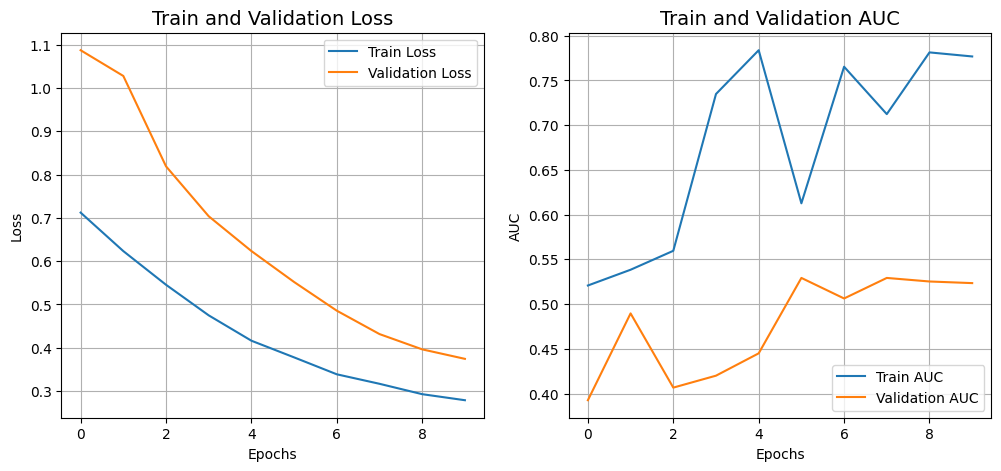

In [22]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2) 
    plt.plot(history['train_auc'], label='Train AUC')
    plt.plot(history['val_auc'], label='Validation AUC')
    plt.title('Train and Validation AUC', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid()

    plt.show()

plot_history(history)